In [ ]:
Instalasi PyTorch

In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset/personality'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [9]:
inputs, classes = next(iter(dataloaders['train']))

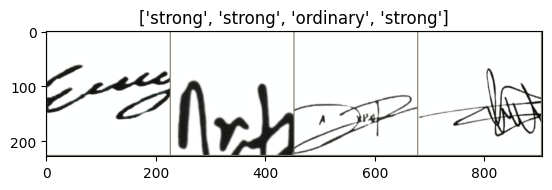

In [10]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # 2 kelas (strong and ordinary)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Menggunakan SGD dengan momentum
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Langkah 6: Scheduler untuk Mengurangi Learning Rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\aanid\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aanid\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [13]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Setiap epoch memiliki fase training dan fase testing
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model ke mode training
            else:
                model.eval()   # Set model ke mode evaluasi

            running_loss = 0.0
            running_corrects = 0

            # Iterasi melalui data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8338 Acc: 0.6000
test Loss: 0.7920 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.8796 Acc: 0.4000
test Loss: 0.6597 Acc: 0.5500

Epoch 2/24
----------
train Loss: 0.7412 Acc: 0.5625
test Loss: 0.7007 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.8300 Acc: 0.5875
test Loss: 0.8461 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.7321 Acc: 0.5750
test Loss: 0.6615 Acc: 0.6500

Epoch 5/24
----------
train Loss: 0.8029 Acc: 0.5500
test Loss: 0.6777 Acc: 0.6500

Epoch 6/24
----------
train Loss: 0.7224 Acc: 0.6125
test Loss: 0.9745 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.7157 Acc: 0.6250
test Loss: 0.7073 Acc: 0.6000

Epoch 8/24
----------
train Loss: 0.5933 Acc: 0.7000
test Loss: 0.7127 Acc: 0.6500

Epoch 9/24
----------
train Loss: 0.5582 Acc: 0.7125
test Loss: 0.6938 Acc: 0.6000

Epoch 10/24
----------
train Loss: 0.5510 Acc: 0.6875
test Loss: 0.7285 Acc: 0.6000

Epoch 11/24
----------
train Loss: 0.5197 Acc: 0.7500
test Loss: 0.6731 Acc

In [16]:
def evaluate_model(model, dataloaders, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

preds, labels = evaluate_model(model_ft, dataloaders, class_names, device)

              precision    recall  f1-score   support

    ordinary       0.64      0.90      0.75        10
      strong       0.83      0.50      0.62        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20

[[9 1]
 [5 5]]


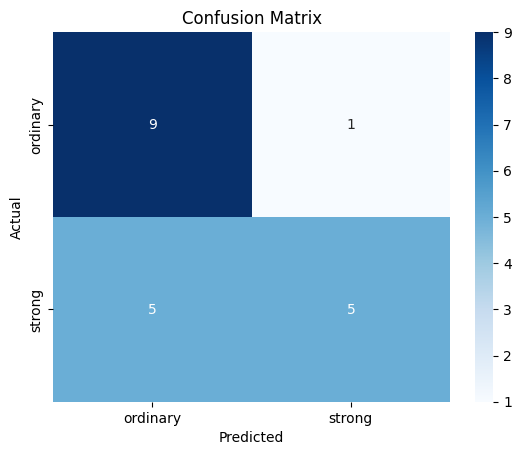

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(labels, preds, target_names=class_names))
print(confusion_matrix(labels, preds))

# Plot confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
torch.save(model_ft.state_dict(), 'resnet50_personality_model.pth')
print("Model telah disimpan.")

Model telah disimpan.
